In [1]:
%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1,'../src')
sys.path.insert(1,'../')

matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']
from __future__ import print_function
import timeit
from ellipsoid import *

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Test distributions

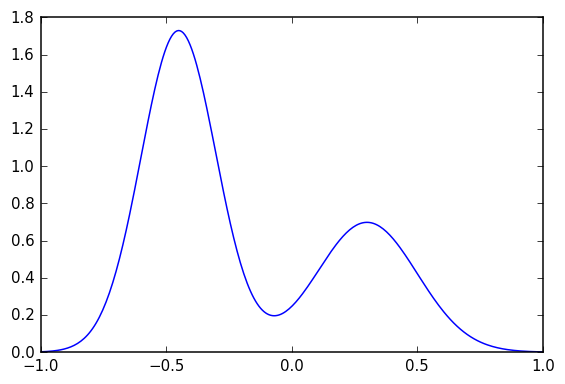

In [2]:
mixture_params = ((.65, -.45, .15), (.35, .3, .2))
gmm = mixture_distribution([normal_distribution(-.45, .15), normal_distribution(.3, .2)], [.65, .35])
fig = plot_distribution(gmm, (-1, 1))

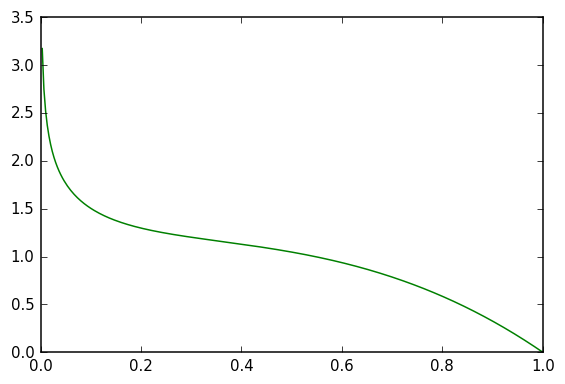

In [3]:
beta = mixture_distribution([beta_distribution(.8, 4), beta_distribution(2, 2)], [.4, .6])
fig = plot_distribution(beta, (0, 1), color='green')

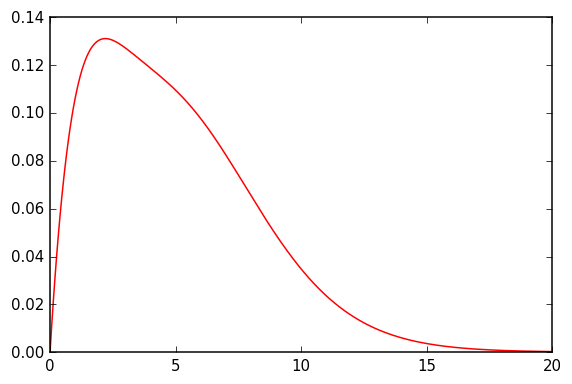

In [4]:
gamma = mixture_distribution([gamma_distribution(2.0, 2.0), gamma_distribution(7.5, 1.0)], [.7, .3])
fig = plot_distribution(gamma, (0, 20), color='red')

### Experiment code

In [5]:
def run_experiment(distribution, estimator, n_vals, num_trials):
    ret_time = np.zeros((len(n_vals), num_trials))
    ret_error = np.zeros((len(n_vals), num_trials))
    overall_start = timeit.default_timer()
    for ii, n in enumerate(n_vals):
        print('n = {} ... '.format(n), end='')
        start = timeit.default_timer()
        total_estimation_time = 0.0
        for jj in range(num_trials):
            samples = sorted(distribution.draw_samples(n))
            result, time = estimator(samples)
            total_estimation_time += time
            ret_time[ii, jj] = time
            ret_error[ii, jj] = piecewise_poly_error_function(result, samples, distribution)
        end = timeit.default_timer()
        print('total time: {} seconds, total estimation time: {} seconds.'.format(float(end - start), total_estimation_time))
        print
    overall_stop = timeit.default_timer()
    print('Experiment took {} seconds'.format(float(overall_stop - overall_start)))
    return ret_time, ret_error

def piecewise_poly_error_function(h, samples, distribution):
    smin = np.min(samples) - 1e-3
    smax = np.max(samples) + 1e-3
    return compute_l1_quad(distribution.get_pdf(), get_ppoly_pdf(h), (smin, smax))

def piecewise_linear_estimator(samples):
    n = len(samples)
    smin = np.min(samples) - 1e-3
    smax = np.max(samples) + 1e-3
    samples_cpp = ellipsoid_cpp.DoubleVector(samples)
    
    t = 20
    eps = math.sqrt(2 * t / float(n))
    num_initial_intervals = min(n, int(math.ceil(t / eps)))
    num_merged_intervals_holdout = t
    max_final_num_intervals = 2 * num_merged_intervals_holdout + 1

    h = ellipsoid_cpp.LinearPieceVector()
    opts = ellipsoid_cpp.A1ProjectionOptions()
    opts.max_gap = eps / (4.0 * max_final_num_intervals)
    opts.max_num_iterations = 20
    opts.num_initial_interval_levels = 2
    stats = ellipsoid_cpp.A1ProjectionStats()

    start = timeit.default_timer()
    ellipsoid_cpp.piecewise_linear_approx(samples_cpp, smin, smax, num_initial_intervals, num_merged_intervals_holdout, max_final_num_intervals, opts, h, stats)
    stop = timeit.default_timer()
    
    return convert_piecewise_linear_to_pp_hypothesis(h), float(stop - start)

### Running the experiments

In [6]:
# For the experiments in the paper, use
#
# n_vals = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000]
# num_trials = 100
#
# The values below are for smaller experiments.

n_vals = [1000, 2000, 5000, 10000]
num_trials = 10
distributions = [('gmm', gmm), ('beta', beta), ('gamma', gamma)]

In [7]:
results = {}
results['n_vals'] = n_vals
results['num_trials'] = num_trials
dist_results = {}
for name, dist in distributions:
    print('Running experiment for distribution {} ...'.format(name))
    time, error = run_experiment(dist, piecewise_linear_estimator, n_vals, num_trials)
    new_entry = {}
    new_entry['time'] = time
    new_entry['error'] = error
    dist_results[name] = new_entry
    print('')
results['distribution_results'] = dist_results

Running experiment for distribution gmm ...
n = 1000 ... total time: 2.42517805099 seconds, total estimation time: 0.120450735092 seconds.
n = 2000 ... total time: 1.17623710632 seconds, total estimation time: 0.154867172241 seconds.
n = 5000 ... total time: 0.858893871307 seconds, total estimation time: 0.214730262756 seconds.
n = 10000 ... total time: 0.616302967072 seconds, total estimation time: 0.266819238663 seconds.
Experiment took 5.07816100121 seconds

Running experiment for distribution beta ...
n = 1000 ... total time: 5.22467803955 seconds, total estimation time: 0.116988658905 seconds.
n = 2000 ... total time: 6.49191308022 seconds, total estimation time: 0.150669574738 seconds.
n = 5000 ... total time: 2.26876282692 seconds, total estimation time: 0.209112405777 seconds.
n = 10000 ... total time: 2.60463619232 seconds, total estimation time: 0.274613380432 seconds.
Experiment took 16.5914831161 seconds

Running experiment for distribution gamma ...
n = 1000 ... total time

### Processing and storing the output

In [8]:
def process_output(rtime, rerror):
    time_avg = np.mean(rtime, axis=1)
    error_avg = np.mean(rerror, axis=1)
    time_err_low = time_avg - np.percentile(rtime, 0.0, axis=1)
    time_err_high = np.percentile(rtime, 90.0, axis=1) - time_avg
    error_std = np.std(rerror, axis=1)
    return time_avg, error_avg, time_err_low, time_err_high, error_std

def process_results(res):
    for name in res['distribution_results']:
        cur_res = res['distribution_results'][name]
        time_avg, error_avg, time_err_low, time_err_high, error_std = process_output(cur_res['time'], cur_res['error'])
        cur_res['time_avg'] = time_avg
        cur_res['error_avg'] = error_avg
        cur_res['time_error_low'] = time_err_low
        cur_res['time_error_high'] = time_err_high
        cur_res['error_std'] = error_std

process_results(results)

In [9]:
output_prefix = 'piecewise_linear_results_'
output_suffix = '.txt'

def write_results_file(filename, res, n_vals):
    with open(filename, 'w') as f:
        f.write('n time_avg time_error_low time_error_high error_avg error_std\n')
        lines = zip(n_vals, res['time_avg'], res['time_error_low'], res['time_error_high'], res['error_avg'], res['error_std'])
        for line in lines:
            for val in line:
                f.write('{} '.format(val))
            f.write('\n')

for name in results['distribution_results']:
    filename = output_prefix + name + output_suffix
    write_results_file(filename, results['distribution_results'][name], results['n_vals'])

### Time and error plots

In [10]:
plot_order = [('gmm', 'blue'), ('beta', 'green'), ('gamma', 'red')]

(0, 10250.0)

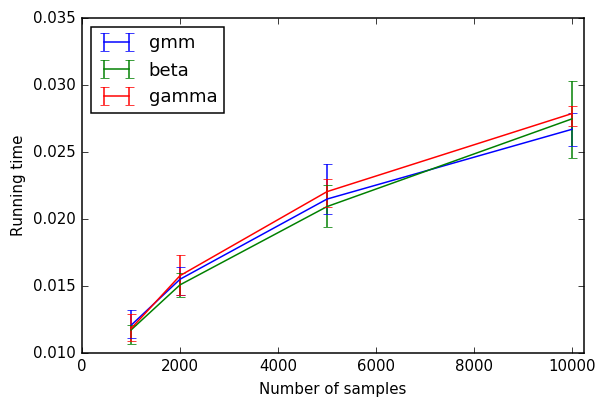

In [11]:
for name, color in plot_order:
    res = results['distribution_results'][name]
    errorbar(n_vals, res['time_avg'], yerr=[res['time_error_low'], res['time_error_high']], color=color, label=name)
xlabel('Number of samples')
ylabel('Running time')
legend(loc=2)
xlim([0, n_vals[-1] * 1.025])

(1000.0, 11000.0)

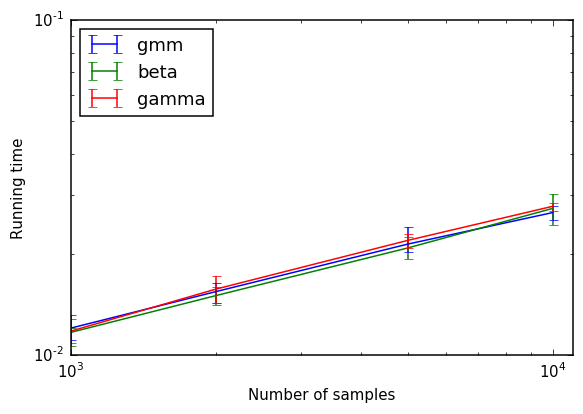

In [12]:
for name, color in plot_order:
    res = results['distribution_results'][name]
    errorbar(n_vals, res['time_avg'], yerr=[res['time_error_low'], res['time_error_high']], color=color, label=name)
xlabel('Number of samples')
ylabel('Running time')
xscale('log')
yscale('log')
legend(loc=2)
xlim([0, n_vals[-1] * 1.1])

(-250.0, 10250.0)

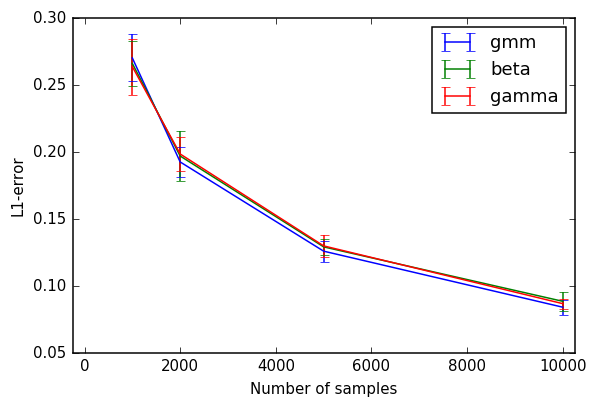

In [13]:
for name, color in plot_order:
    res = results['distribution_results'][name]
    errorbar(n_vals, res['error_avg'], yerr=res['error_std'], color=color, label=name)
xlabel('Number of samples')
ylabel('L1-error')
legend()
xlim([n_vals[-1] * -.025, n_vals[-1] * 1.025])

(1000.0, 11000.0)

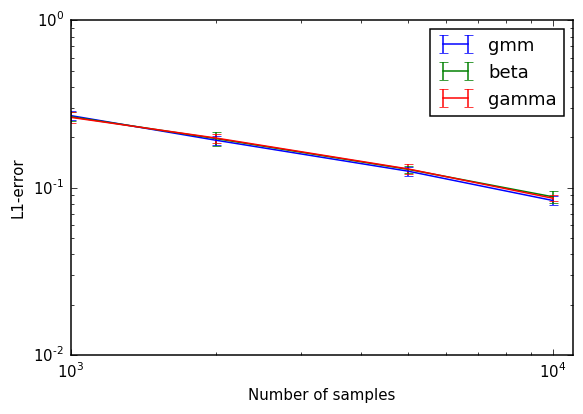

In [14]:
for name, color in plot_order:
    res = results['distribution_results'][name]
    errorbar(n_vals, res['error_avg'], yerr=res['error_std'], color=color, label=name)
xlabel('Number of samples')
ylabel('L1-error')
xscale('log')
yscale('log')
legend()
xlim([0, n_vals[-1] * 1.1])

### Error plot slope

In [15]:
gmm_error_avg = results['distribution_results']['gmm']['error_avg']
gmm_error_avg

array([ 0.27009219,  0.19243216,  0.12581228,  0.08397093])

In [16]:
(log(gmm_error_avg[-1]) - log(gmm_error_avg[0])) / (log(n_vals[-1]) - log(n_vals[0]))

-0.50738307078854106

### Full results

In [17]:
results

{'distribution_results': {'beta': {'error': array([[ 0.27049491,  0.28788894,  0.26208692,  0.30223718,  0.26307965,
            0.24714302,  0.26385927,  0.25287451,  0.26546861,  0.24457579],
          [ 0.20705374,  0.16158461,  0.19205128,  0.21847686,  0.21242961,
            0.18681973,  0.21660874,  0.17406683,  0.21086879,  0.18883517],
          [ 0.13028015,  0.12765486,  0.12274309,  0.12429716,  0.13598527,
            0.125817  ,  0.12796186,  0.13435995,  0.12032343,  0.14069963],
          [ 0.09317249,  0.09905052,  0.09905668,  0.09148305,  0.07784493,
            0.08052359,  0.08653258,  0.07969435,  0.08671772,  0.08957095]]),
   'error_avg': array([ 0.26597088,  0.19687954,  0.12901224,  0.08836469]),
   'error_std': array([ 0.01681672,  0.01830869,  0.00604656,  0.00718465]),
   'time': array([[ 0.011374  ,  0.01167297,  0.01122689,  0.01141715,  0.01144409,
            0.01575398,  0.01092696,  0.0106678 ,  0.01110387,  0.01140094],
          [ 0.01494503,  0.014

### Storing the distribution data

In [18]:
distribution_prefix = 'distribution_plot_data_'
distribution_suffix = '.txt'

def write_distribution_plot_data(filename, distribution, (l, r), num_points=1000):
    with open(filename, 'w') as f:
        f.write('x y\n')
        xs = np.linspace(l, r, num_points)
        ys = distribution.get_pdf()(xs)
        for x, y in zip(xs, ys):
            f.write('{} {}\n'.format(x, y))

distributions = [('gmm', gmm, (-1.0, 1.0)), ('beta', beta, (0.0, 1.0)), ('gamma', gamma, (0.0, 20.0))]

for name, distribution, range in distributions:
    filename = distribution_prefix + name + distribution_suffix
    write_distribution_plot_data(filename, distribution, range)

### Estimating the constant in the VC Inequality

In [24]:
40.0 * 2 / (gmm_error_avg[-1] ** 2)

11345.720733943939

In [25]:
gmm_error_avg[-1]

0.083970927213484037

In [27]:
2 * gmm_error_avg[-1] **-2

283.64301834859845